In [19]:
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import Backgammon as B
import agent as A
import flipped_agent as FA

import pubeval

In [10]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
        
    def choose_board(self, board):
        self.board = board
        self.done = False
        return np.copy(self.board)
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], self.board
        n_boards = np.shape(boards)[0]
        tesauro = np.zeros((n_boards, 198))
        for b in range(n_boards):
            tesauro[b,:] = features(boards[b], player)
        return moves, tesauro
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player):
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        tesauro_board = features(np.copy(self.board), player)
        return tesauro_board, reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

In [3]:
def reset_graph(seed=43):
    #tf.reset_default_graph()
    #tf.set_random_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
reset_graph()

In [12]:
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H1, H2, D_out = 198, 256, 128, 1

actor = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, D_out),
    torch.nn.Softmax(dim=0),
)
critic = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, D_out),
    torch.nn.Tanh(),
)

In [5]:
def get_action_and_value(actor, boards):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    with torch.no_grad():
        action = int(torch.multinomial(possible_actions_probs.view(1,-1), 1))
    action_value = possible_actions_probs[action]
    return action, action_value

def get_action_value(actor, boards, action):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    action_value = possible_actions_probs[action]
    return action_value

def get_action(actor, boards):
    with torch.no_grad():
        boards = torch.from_numpy(boards).float()
        possible_actions_probs = actor(boards)
        action = torch.multinomial(possible_actions_probs.view(1,-1), 1)
    return int(action)

def get_state_value(nn_model, after_state):
    after_state = torch.from_numpy(after_state).float()
    value = nn_model(after_state)
    return value

def epsilon_greedy(critic, possible_boards, epsilon=.9):
    possible_boards = torch.from_numpy(possible_boards).float()
    values = critic(possible_boards)
    if np.random.random()<epsilon:
        _ , index = values.max(0)
    else:
        index = np.random.randint(0, len(possible_boards))
    return int(index)

In [7]:

"""
Use: f = features(board)
Input: board is is a 29-vector
Output: f is a 198-vector of features that follows Tesauro's procedure.
        See p. 423 in Sutton & Barto
"""
def features(board, player):
    f = np.zeros(198)
    
    # define features for points on board
    p = 0
    for i in range(1,25):
        point = board[i]
        #print('point:', point)
        #print('p: ', p)
        if (point != 0):
            #print('Not 0')
            if(point > 0):
                if (point == 1):
                    f[p] = 1
                elif (point == 2):
                    f[p+1] = 1
                elif (point == 3):
                    f[p+2] = 1
                else:
                    f[p+3] = (point-3)/2
            else:
                if (point == -1):
                    f[p+4] == 1
                elif (point == -2):
                    f[p+5] = 1
                elif (point == -3):
                    f[p+6] = 1
                else:
                    f[p+7] = (-point-3)/2
        p += 8
    
    f[192] = board[25]/2
    f[193] = board[26]/2
    f[194] = board[27]/15
    f[195] = board[28]/15
    f[196] = int(player == 1)
    f[197] = int(player == -1)
    return f

In [16]:
import time
rew_plt = []

def playAgainstRandom(num_games = 100, clear = True):
    global rew_plt
    rew = []
    for episode in range(num_games):
        env.reset()
        done = False

        while not done:
            dice = B.roll_dice()
            for i in range(1 + int(dice[0] == dice[1])):
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                if len(possible_moves) == 0:
                    break
                action = get_action(actor, possible_boards)
                after_state, reward, done = env.step(possible_moves[action], player = 1)
                if done:
                    break

            if not done:
                dice = B.roll_dice()
                for i in range(1 + int(dice[0] == dice[1])):
                    next_state, reward, done = env.make_move(dice)
                    if done:
                        break


        rew.append(reward)

    if clear:
        clear_output(True)
    rew_plt.append(np.mean(np.equal(rew,1)))
    rew = []
    plt.plot(rew_plt)
    plt.axhline(0.5, color="gray")
    plt.show()
    print("Win rate:", rew_plt[-1])

In [22]:
import time
pubRew_plt = []

def playPubeval(num_games = 100, clear = True):
    global pubRew_plt
    pubRew = []
    for episode in range(num_games):
        env.reset()
        done = False

        while not done:
            dice = B.roll_dice()
            for i in range(1 + int(dice[0] == dice[1])):
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                if len(possible_moves) == 0:
                    break
                action = get_action(actor, possible_boards)
                after_state, reward, done = env.step(possible_moves[action], player = 1)
                if done:
                    break

            if not done:
                dice = B.roll_dice()
                for i in range(1 + int(dice[0] == dice[1])):
                    action = pubeval.agent_pubeval(np.copy(env.board), dice, oplayer = -1)
                    next_state, reward, done = env.step(action, player = -1)
                    if done:
                        reward = -1
                        break


        pubRew.append(reward)

    if clear:
        clear_output(True)
    pubRew_plt.append(np.mean(np.equal(pubRew,1)))
    pubRew = []
    plt.plot(pubRew_plt)
    plt.axhline(0.5, color="gray")
    plt.show()
    print("Win rate:", pubRew_plt[-1])

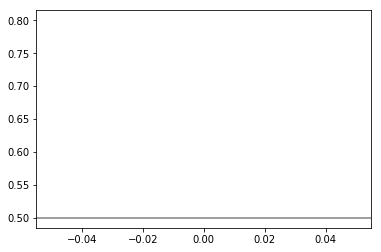

Win rate: 0.8


In [23]:
playPubeval(num_games = 10, clear = False)

EPISODE:  20 Steps: 52
EPISODE:  40 Steps: 25
EPISODE:  60 Steps: 23
EPISODE:  80 Steps: 45
EPISODE:  100 Steps: 79


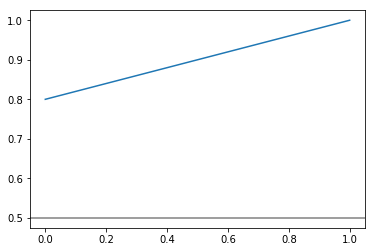

Win rate: 1.0
Time per 100: 40.10226631164551
EPISODE:  100
EPISODE:  120 Steps: 38
EPISODE:  140 Steps: 51
EPISODE:  160 Steps: 23
EPISODE:  180 Steps: 64
EPISODE:  200 Steps: 30


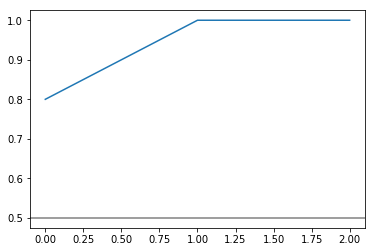

Win rate: 1.0
Time per 100: 41.55054497718811
EPISODE:  200
EPISODE:  220 Steps: 41
EPISODE:  240 Steps: 70
EPISODE:  260 Steps: 45
EPISODE:  280 Steps: 36
EPISODE:  300 Steps: 34


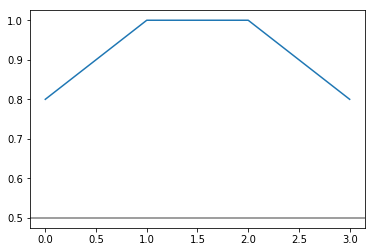

Win rate: 0.8
Time per 100: 35.61952781677246
EPISODE:  300
EPISODE:  320 Steps: 69
EPISODE:  340 Steps: 73
EPISODE:  360 Steps: 42
EPISODE:  380 Steps: 54
EPISODE:  400 Steps: 50


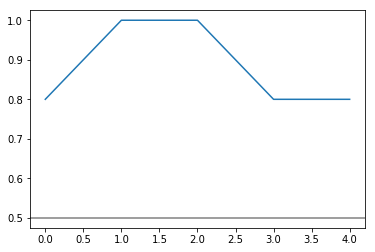

Win rate: 0.8
Time per 100: 38.15568232536316
EPISODE:  400
EPISODE:  420 Steps: 35
EPISODE:  440 Steps: 40
EPISODE:  460 Steps: 54
EPISODE:  480 Steps: 95
EPISODE:  500 Steps: 58


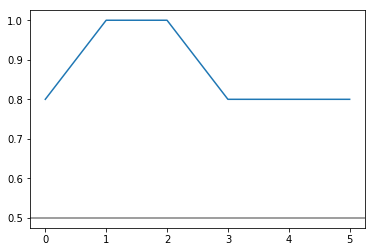

Win rate: 0.8
Time per 100: 41.36671757698059
EPISODE:  500
EPISODE:  520 Steps: 59
EPISODE:  540 Steps: 24
EPISODE:  560 Steps: 142
EPISODE:  580 Steps: 36
EPISODE:  600 Steps: 27


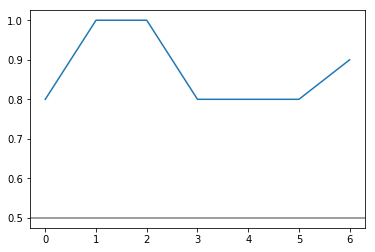

Win rate: 0.9
Time per 100: 46.867369413375854
EPISODE:  600
EPISODE:  620 Steps: 51
EPISODE:  640 Steps: 32
EPISODE:  660 Steps: 53
EPISODE:  680 Steps: 31
EPISODE:  700 Steps: 64


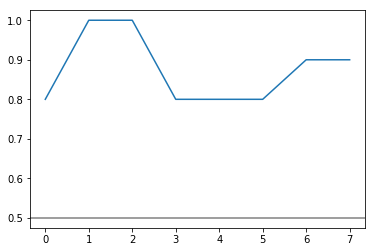

Win rate: 0.9
Time per 100: 39.031415700912476
EPISODE:  700
EPISODE:  720 Steps: 34
EPISODE:  740 Steps: 83
EPISODE:  760 Steps: 55
EPISODE:  780 Steps: 40
EPISODE:  800 Steps: 40


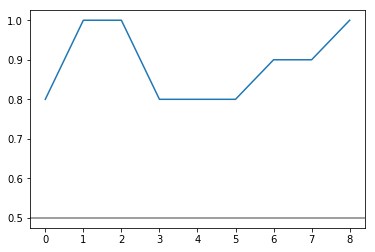

Win rate: 1.0
Time per 100: 42.6460747718811
EPISODE:  800
EPISODE:  820 Steps: 38
EPISODE:  840 Steps: 135
EPISODE:  860 Steps: 81
EPISODE:  880 Steps: 44
EPISODE:  900 Steps: 43


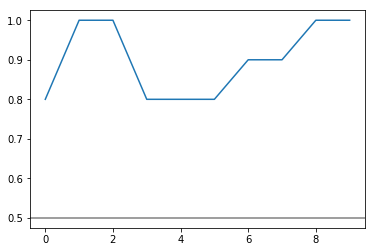

Win rate: 1.0
Time per 100: 55.64688754081726
EPISODE:  900
EPISODE:  920 Steps: 48
EPISODE:  940 Steps: 44
EPISODE:  960 Steps: 47
EPISODE:  980 Steps: 51
EPISODE:  1000 Steps: 49


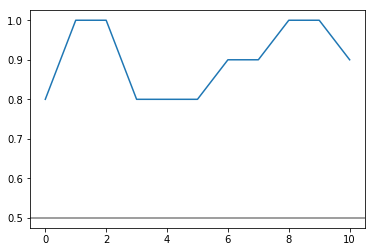

Win rate: 0.9
Time per 100: 37.527119874954224
EPISODE:  1000
EPISODE:  1020 Steps: 62
EPISODE:  1040 Steps: 33
EPISODE:  1060 Steps: 60
EPISODE:  1080 Steps: 60
EPISODE:  1100 Steps: 52


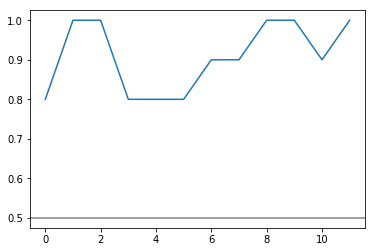

Win rate: 1.0
Time per 100: 45.88271760940552
EPISODE:  1100
EPISODE:  1120 Steps: 67
EPISODE:  1140 Steps: 51
EPISODE:  1160 Steps: 51
EPISODE:  1180 Steps: 37
EPISODE:  1200 Steps: 54


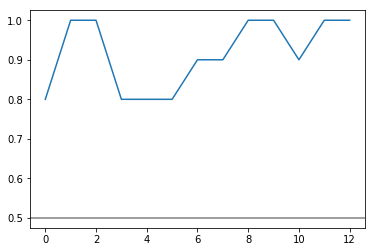

Win rate: 1.0
Time per 100: 42.25460886955261
EPISODE:  1200
EPISODE:  1220 Steps: 30
EPISODE:  1240 Steps: 47
EPISODE:  1260 Steps: 49
EPISODE:  1280 Steps: 92
EPISODE:  1300 Steps: 36


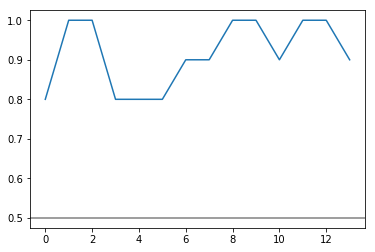

Win rate: 0.9
Time per 100: 38.41042423248291
EPISODE:  1300
EPISODE:  1320 Steps: 46
EPISODE:  1340 Steps: 68
EPISODE:  1360 Steps: 42
EPISODE:  1380 Steps: 26
EPISODE:  1400 Steps: 39


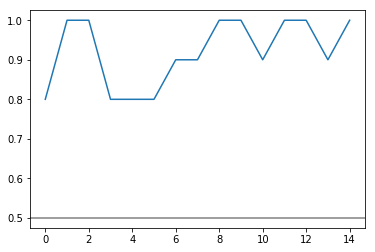

Win rate: 1.0
Time per 100: 38.73940300941467
EPISODE:  1400
EPISODE:  1420 Steps: 61
EPISODE:  1440 Steps: 57
EPISODE:  1460 Steps: 30
EPISODE:  1480 Steps: 33
EPISODE:  1500 Steps: 69


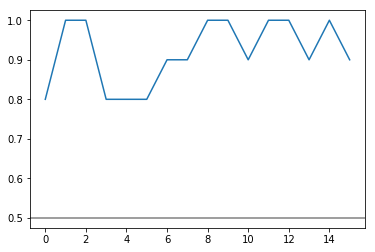

Win rate: 0.9
Time per 100: 41.440900802612305
EPISODE:  1500
EPISODE:  1520 Steps: 27
EPISODE:  1540 Steps: 48
EPISODE:  1560 Steps: 46
EPISODE:  1580 Steps: 41
EPISODE:  1600 Steps: 36


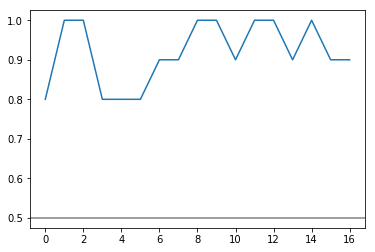

Win rate: 0.9
Time per 100: 34.50724744796753
EPISODE:  1600
EPISODE:  1620 Steps: 40
EPISODE:  1640 Steps: 22
EPISODE:  1660 Steps: 56
EPISODE:  1680 Steps: 36
EPISODE:  1700 Steps: 54


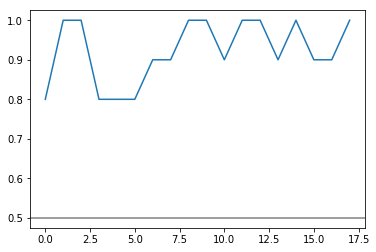

Win rate: 1.0
Time per 100: 29.4994158744812
EPISODE:  1700
EPISODE:  1720 Steps: 34
EPISODE:  1740 Steps: 43
EPISODE:  1760 Steps: 47
EPISODE:  1780 Steps: 36


KeyboardInterrupt: 

In [24]:
gamma = 1
actor_alpha = 0.01
critic_alpha = 0.01
actor_lambda = 0.7
critic_lambda = 0.7
forever = 5000

plt_iter = 100

env = backgammon()
tic = time.time()
step = 1

for episode in range(1,forever+1):
    if (episode%20==0):
        print("EPISODE: ", episode, "Steps:", step)

    env.reset()
    done = False
    step = 1
    
    I = 1
    actor_Z = [ [0 for layer in actor.parameters()] for player in range(2) ]
    critic_Z = [ [0 for layer in critic.parameters()] for player in range(2) ]
    value = [[0,0],[0,0]] #value[player][0(old),1(new)]
        
    player = 0
    while not done:
        dice = B.roll_dice()
        for i in range(1 + int(dice[0] == dice[1])):
            possible_moves, possible_boards = env.legal_moves(dice, 1)
            if len(possible_moves) == 0:
                break
            action, pi = get_action_and_value(actor, possible_boards) # Using actor
            pi.clamp(min=1e-8) # so that log does not become nan
            log_pi = torch.log(pi) 
            actor.zero_grad()
            log_pi.backward()
            with torch.no_grad():
                for i, param in enumerate(actor.parameters()):
                    actor_Z[player][i] = actor_lambda * I * actor_Z[player][i] + param.grad
            after_state, reward, done = env.step(possible_moves[action], player = 1)
            if done:
                break
                
        if not done:
            value[player][0] = float(value[player][1]) # old_value
            value[player][1] = get_state_value(critic, after_state)
            critic.zero_grad()
            value[player][1].backward()
            with torch.no_grad():
                for i, param in enumerate(critic.parameters()):
                    critic_Z[player][i] = critic_lambda * critic_Z[player][i] + param.grad
            if (step>2):
                with torch.no_grad():
                    reward = 0 # Reward er 0
                    delta = reward + gamma*value[player][1] - value[player][0]
                    
                    for i, param in enumerate(actor.parameters()):
                        param += actor_alpha * delta * actor_Z[player][i] 
                    for i, param in enumerate(critic.parameters()):
                        param += critic_alpha * delta * critic_Z[player][i]
            
            if player==0:
                I *= gamma
                step += 1
            player = 1 - player
            env.swap_player()
            
    value[player][0] = float(value[player][1])
    value[player][1] = 0
    
    value[1 - player][0] = float(value[1 - player][1])
    value[1 - player][1] = 0
    
    with torch.no_grad():
        delta1 = reward + gamma*value[player][1] - value[player][0]
        delta2 = -reward + gamma*value[1 - player][1] - value[1 - player][0]
        
        for i, param in enumerate(actor.parameters()):
            param += actor_alpha * delta1 * actor_Z[player][i]
            param += actor_alpha * delta2 * actor_Z[1 - player][i] 
        for i, param in enumerate(critic.parameters()):
            param += critic_alpha * delta1 * critic_Z[player][i]
            param += critic_alpha * delta2 * critic_Z[1 - player][i]
            
    if episode%plt_iter == 0:
        toc = time.time()
        playPubeval(num_games = 10, clear = False)
        print("Time per {}: {}".format(plt_iter, toc-tic))
        print("EPISODE: ", episode)
        tic = time.time()
        

